In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-in-csv/mnist_test.csv
/kaggle/input/mnist-in-csv/mnist_train.csv


In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [49]:
class CSVDataset(Dataset):
    def __init__(self, csv_file):
        df = pd.read_csv(csv_file)
        self.data = df[(df['label'] ==5) | (df['label'] ==6) | (df['label'] ==7) | (df['label'] ==0) | (df['label'] ==2)]
        self.X = self.data.iloc[:, 1:].values
        self.X = self.X.reshape(-1,1, 28, 28).astype(np.float32)/255
        label_map = {0: 0, 2: 1, 5: 2, 6: 3, 7: 4}
        self.y = self.data['label'].map(label_map).values
        #self.y = self.data.iloc[:, -1].values
        

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y=torch.tensor(self.y[idx], dtype=torch.long)
        return x, y

In [50]:
train_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_train.csv')
test_dataset = CSVDataset('/kaggle/input/mnist-in-csv/mnist_test.csv')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [52]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        #use dropout=0.3 when overfitting
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, x):
        x = x.squeeze(1)
        h0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, (h0, c0))
        out = self.fc(out[:,-1,:])
        return out



In [53]:
def model_training(model, criterion, optimizer, epochs=50):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0
        total_train = 0
        correct_train = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            value, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted==labels).sum().item()
            total_train += labels.size(0)

        
        avg_train_loss = total_train_loss/len(train_loader)
        train_accuracy = correct_train/total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        correct_test = 0
        total_test = 0
        total_test_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                correct_test+=(predicted==labels).sum().item()
                total_test +=labels.size(0)

        avg_test_loss = total_test_loss / len(test_loader)
        test_accuracy = correct_test / total_test
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}% | "
                  f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy*100:.2f}%")

    return train_losses, test_losses, train_accuracies, test_accuracies


In [54]:
model = RNN(28, 128, 5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)


In [55]:
train_losses, test_losses, train_accuracies, test_accuracies = model_training(model, criterion, optimizer, epochs=50)

Epoch 1/50 | Train Loss: 1.5996, Train Acc: 28.24% | Test Loss: 1.5489, Test Acc: 38.65%
Epoch 2/50 | Train Loss: 1.2893, Train Acc: 45.14% | Test Loss: 0.9628, Test Acc: 62.99%
Epoch 3/50 | Train Loss: 0.7573, Train Acc: 74.42% | Test Loss: 0.5895, Test Acc: 81.53%
Epoch 4/50 | Train Loss: 0.4861, Train Acc: 85.34% | Test Loss: 0.4149, Test Acc: 88.18%
Epoch 5/50 | Train Loss: 0.3652, Train Acc: 89.24% | Test Loss: 0.3328, Test Acc: 90.33%
Epoch 6/50 | Train Loss: 0.2991, Train Acc: 91.11% | Test Loss: 0.2795, Test Acc: 91.51%
Epoch 7/50 | Train Loss: 0.2547, Train Acc: 92.38% | Test Loss: 0.2429, Test Acc: 92.62%
Epoch 8/50 | Train Loss: 0.2232, Train Acc: 93.36% | Test Loss: 0.2244, Test Acc: 93.37%
Epoch 9/50 | Train Loss: 0.1992, Train Acc: 93.99% | Test Loss: 0.1982, Test Acc: 93.93%
Epoch 10/50 | Train Loss: 0.1801, Train Acc: 94.62% | Test Loss: 0.1800, Test Acc: 94.46%
Epoch 11/50 | Train Loss: 0.1644, Train Acc: 95.07% | Test Loss: 0.1758, Test Acc: 94.46%
Epoch 12/50 | Train

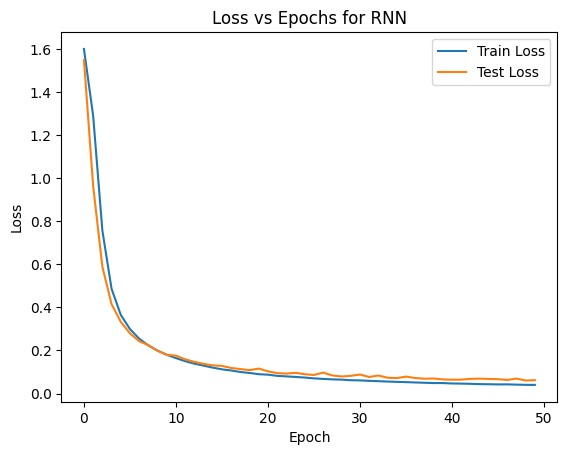

In [56]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs for RNN")
plt.legend()
plt.show()

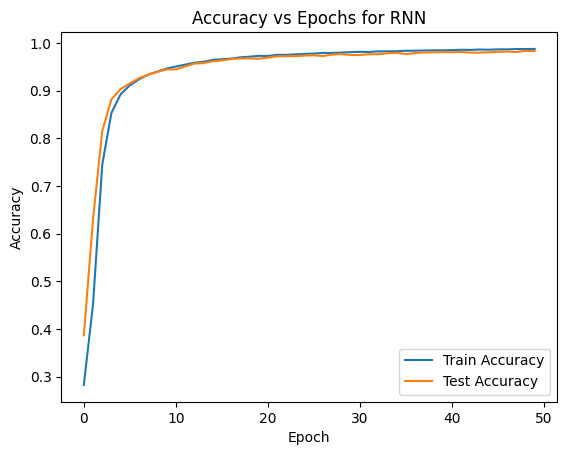

In [57]:
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs for RNN")
plt.legend()
plt.show()

In [58]:
def plot_predictions(model, test_loader, num_images=8):
    model.eval()
    images_shown = 0
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    label_map_reverse = {0: 0, 1: 2, 2: 5, 3: 6, 4: 7}
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for img, pred, label in zip(images, preds, labels):
                if images_shown == num_images:
                    break
                img = img.squeeze(0).cpu().numpy()
                axes[images_shown].imshow(img, cmap='gray')
                axes[images_shown].set_title(f"Pred: {label_map_reverse[pred.item()]}\nTrue: {label_map_reverse[label.item()]}")
                axes[images_shown].axis('off')
                images_shown += 1
            if images_shown == num_images:
                break

    plt.tight_layout()
    plt.show()


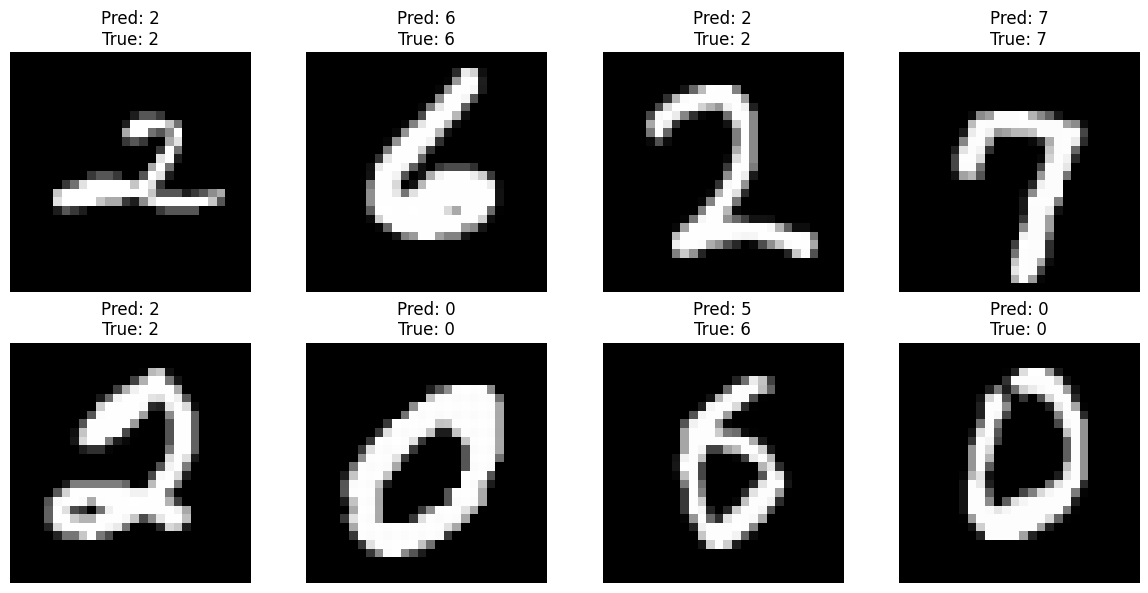

In [59]:

# Call this after training
plot_predictions(model, test_loader)